In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock price data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I used the Pandas library DataReader to get the historical price stock data from Yahoo Finance API.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  In addition, I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing  COVID-19 vaccines: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

What are technical Indicators?  Technical indicators are quick methods or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis. https://www.investopedia.com/terms/t/technicalindicator.asp Technical indicators are signals produced from the patterns observed in the movements of stock prices (high, low, open, close) and volumes.  These signals are in turn used to predict the future price movements. Techincal Indicators as used in this notebook will provide a historical price analysis  regarding volatility and trends of the stock.  Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.<br>
Some basic examples of technical indicators which I will cover are:
1. Simple Moving Averages (SMA)
2. Exponential Moving Averages (EMA)
3. Moving Average Convergence Divergence (MACD) Crossover Strategy
4. Relative Strength Index (RSI)

My technical analysis of the stock prices will focus on answering the following questions  which concern price trends, volatility and forecasting:
### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of whether to buy and sell stocks?<br>
**Answer**: Yes. 
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  Technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, price volatility, RSI and MACD crossover strategies to answer this question.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns?<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2**  An Exponential Moving Average Plot.<br>
**Model 3**  Exponential Moving Average Crossover Stratergy<br>
**Model 4**  Relative Strength Index Plot

### Question 2:
How well do SARIMA algorithms perform when used to forecast future stocks prices?  I will contrast the performance of SARIMA models with data from 'Adj Close' column and data from the above technical indicators.  I will use the RMSE metric to compare the models' performances?<br>
**Model 1** Graph of historical prices for Pfizer stock.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms perform better at predicting stocks prices, LTSM or ARIMA?  I will compare results of both algorithms.<br> 
**Answer:** <br>
**Model 1** is a SARIMA model.<br>


## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-04-12,36.970001,161.639999,175.649994,139.399994,49.419998,121.519997
2021-04-13,37.160000,159.479996,194.660004,149.710007,49.189999,129.639999
2021-04-14,37.169998,159.919998,201.339996,160.029999,49.840000,132.600006


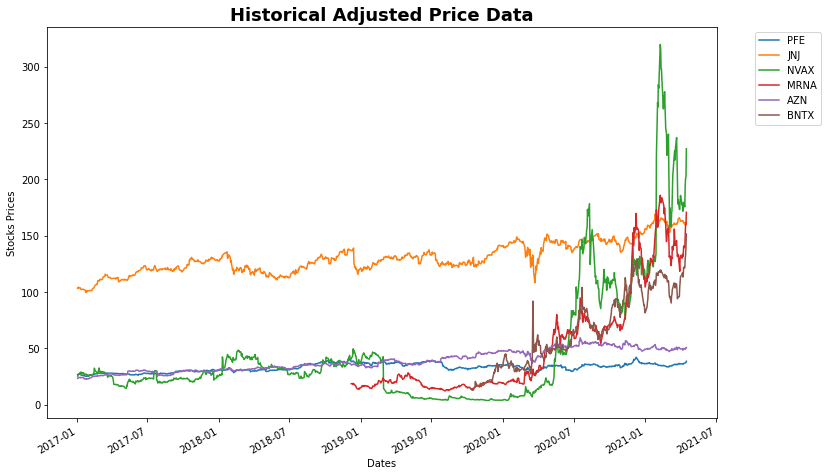

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

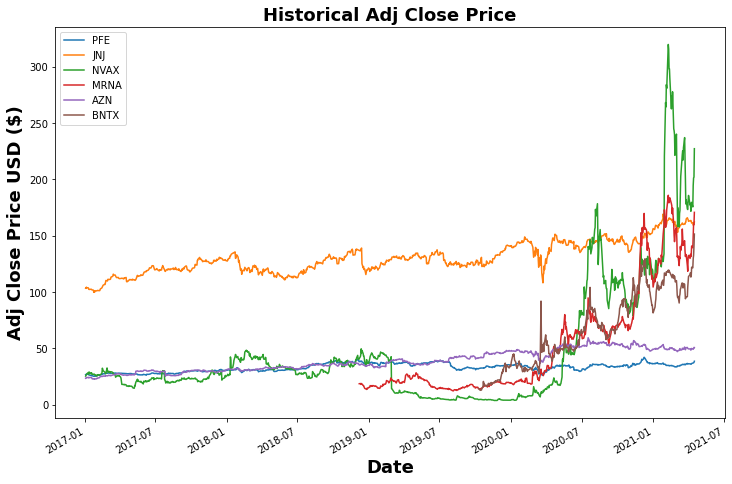

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1079.000000,1079.000000,1079.000000,593.000000,1079.000000,382.000000
mean,32.945688,130.348650,45.900751,52.384646,38.811566,66.914241
std,3.679885,14.080254,54.197299,46.343226,9.190074,32.877648
min,25.159119,99.793396,3.690000,12.260000,22.596422,12.750000
25%,30.103620,120.361317,13.315000,17.990000,30.868015,37.895001
50%,33.300560,128.397079,27.400000,25.730000,36.553543,64.634998
75%,36.122311,140.580093,43.300001,70.839996,47.593040,95.079998
max,42.101986,169.423508,319.929993,185.979996,59.466022,151.539993


### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1079 rows and 6 columns



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-04-12,37.029999,36.330002,36.480000,36.970001,29944900.0,36.970001
2021-04-13,37.650002,36.889999,37.410000,37.160000,33967400.0,37.160000
2021-04-14,37.380001,36.959999,37.169998,37.169998,23842900.0,37.169998


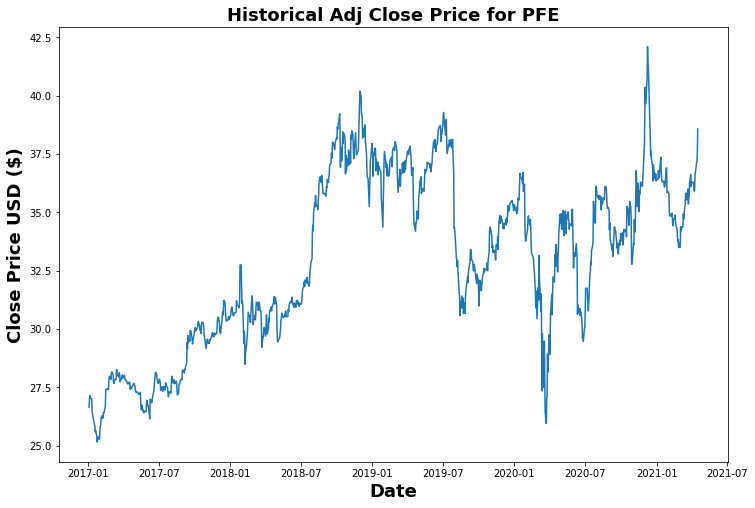

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

,Close,Volume,Adj Close
count,1079.000000,1.079000e+03,1079.000000
mean,35.593561,2.608143e+07,32.945688
std,3.268365,1.362860e+07,3.679885
min,27.030361,5.187683e+06,25.159119
25%,33.490732,1.820416e+07,30.103620
50%,34.889999,2.294432e+07,33.300560
75%,37.590322,2.955374e+07,36.122311
max,43.861481,2.301539e+08,42.101986


#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

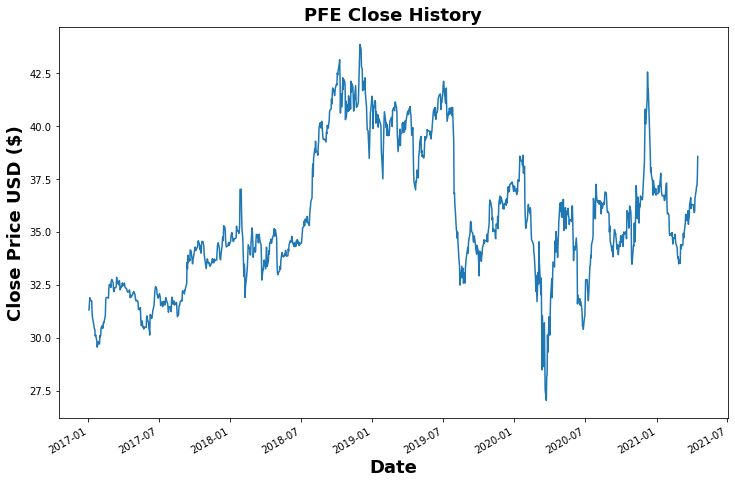

In [14]:
single_plot(pfe_stock_data, stock_value='Close', stock_symbol='PFE')

In [15]:
pfe_stock_data['Adj Close'].describe()

count    1079.000000
mean       32.945688
std         3.679885
min        25.159119
25%        30.103620
50%        33.300560
75%        36.122311
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The practice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is part of algorithmic trading. What are technical indicators and how are they used by Technical Analyst in stock trading?  Technical indicators are methods or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements. https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss the below popular technical indicators which are used in the markets to study price movements:

1. Moving Averages (MA)
    > Simple Moving Average<br>
    > Exponential Moving Average<br>
2. Rate of Change (ROC)
3. Relative Strength Index (RSI)

### Moving Averages
The moving average is also known as the rolling mean or running average.  Moving averages smooth out the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving average smooths out the variations in the dataset by calculating the moving average.  Two common types of moving averages are Simple Moving Average (SMA), and Exponential Moving Average (EMA). <br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the Python rolling method to calculate moving averages.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock. Common time periods used for moving averages are 5, 10, 20, 50, 200 days.  A 10 time period SMA would mean 10 trading days.  In this case I am  considering the past 10 and 50 days and averaging each group, so there won't be any results for these begining entries.<br>  
The below graph pertains to Pfizer stock and looks like the stock price is volatile with lots of fluctuations and noise.  The plot shows the Adj Close price and 10 and 50-day moving averages.  The 10-day follows the Close price pretty closely but smooths out the positve and negative spikes in prices.  The 50-day eliminates most of the volatility.  The SMA smooths out the noise and gives a more accurate picture of how stock performs during volatile periods.<br><br><br>
I would like to highlight certain time periods that highllight how this stock has performed during volatile periods.  Aound 2/18, there was a spike in price from \\$35.00 to almost \\$37.50 and then dropped quickly to almost \\$32.00.  What is the SMA showing us?  SMA gives a more realistic picture of what happened with stock the price. The price increased and dropped precipitously.  We may not know what precipitated such activity, but what were the 10 and 50 day averages around this time period for a more accurate picture of what the stock price was for that period?  How does this compare to performance of the stock in general?  What's interesting is that if we do subsets of for time period of 2/18 to for 10 and 50 averages we can get closer look at what the averge price was.  The average price of the stock was \\$35.578751.  When applying 10 and 50-day the average price is still \\$35.  When I subset the data the average price was \\$34.015994.  When I applied the 10 and 50-day Moving Averages the average price is still a \\$34.052809 and \\$34.168457, respectively.  So is the stock price really that volatile? Not really. <br><br>
Around 8/2019, the price was pretty volatile.  

##### Moving Average Convergence/Divergence Cross Over Stategy
The MACD can be used for for various MAs.  Stock market analysts and investors use the Exponential Moving Average Crossover strategy to analyze price trends and predict upcoming change in trends.  A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset. When the short term moving average crosses above the long term moving average, this indicates a buy signal. However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.  The 50-day moving average is the one that takes longer to adjust to sudden price changes, while the 10-day one is much faster to account for sudden changes.  In the code below I am defining buying and selling signals for the crossover strategy.
The logic of the strategy is as follows:
when the fast MA crosses the slow one upwards, we buy the asset.  When the slow MA crosses the fast one upwards, we sell the asset.
<br>
<br>
For example, around 5/18 there is a signal to puchase.  Around this time the stock was selling for around \\$34.00 per share.  If we had puchased it we could've sold shares around 10/8 for \\$42.00 per share and made a nice profit.  The MACD shows us where the previous trends were with price and potential for making and losing money.  The MACD shows that there is price volatility if looking for short-term investments.  Around 8/18 the price was around \\$41.00. The signal indicats to sell because there is an upcoming signicant drop in price around 9/18 to \\$32.50    

In [16]:
sma_func_calc = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')

In [17]:
def sma_function(data, col1=None, col2=None, col3=None, symbol=None):
    data[col2] = data[col1].rolling(10).mean()
    data[col3] = data[col1].rolling(50).mean()

    data['Signal'] = 0.0
    data['Signal'] = np.where(data[col2] > data[col3], 1.0, 0.0)
    data['Position'] = data['Signal'].diff()

    data = data.dropna()
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = '10-day SMA') 
    data[col3].plot(color = 'green', label = '50-day SMA')
    label_font = {'weight':'bold','size':18}
    plt.title(f'{symbol} Smooth Moving Average',fontdict=label_font)
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = col2) 
    data[col3].plot(color = 'green', label = col3)
    # plot ‘buy’ signals
    plt.plot(data[data['Position'] == 1].index, 
             data[col2][data['Position'] == 1], 
             '^', markersize = 10, color = 'green', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data[col2][data['Position'] == -1], 
             'v', markersize = 10, color = 'red', label = 'sell')
    
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.title(f'{symbol} SMA Crossover Stategy',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)
    plt.grid()
    plt.show()
        
    return data

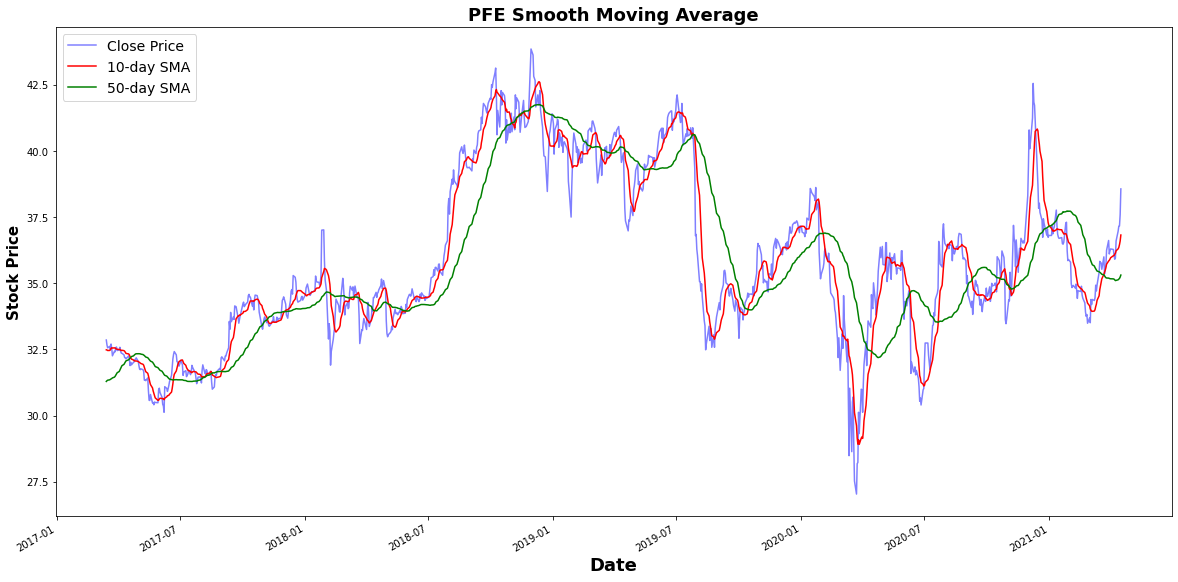

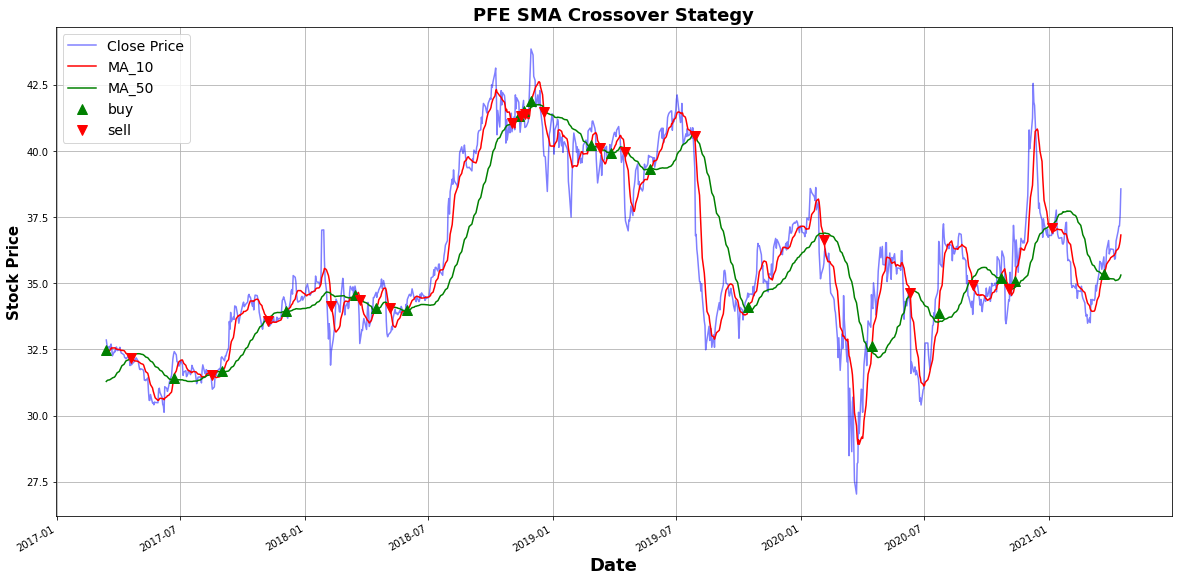

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50,Signal,Position
Date,,,,,,,,,,
2017-03-15,32.922199,32.428844,32.466793,32.855785,24279839.0,28.254789,32.485769,31.289754,1.0,1.0
2017-03-16,32.855785,32.495255,32.798862,32.666035,21816219.0,28.091606,32.478179,31.316888,1.0,0.0
2017-03-17,32.808350,32.514233,32.694496,32.561668,45736117.0,28.001856,32.459203,31.336433,1.0,0.0
2017-03-20,32.732449,32.561668,32.637569,32.618595,18435514.0,28.050808,32.462049,31.351044,1.0,0.0
2017-03-21,32.836811,32.428844,32.713470,32.495255,33083479.0,27.944742,32.486717,31.365655,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-04-12,37.029999,36.330002,36.480000,36.970001,29944900.0,36.970001,36.302999,35.132800,1.0,0.0
2021-04-13,37.650002,36.889999,37.410000,37.160000,33967400.0,37.160000,36.357000,35.158000,1.0,0.0
2021-04-14,37.380001,36.959999,37.169998,37.169998,23842900.0,37.169998,36.462999,35.185400,1.0,0.0


In [18]:
sma_data = sma_function(sma_func_calc,col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_data

In [19]:
sma_data[['Close','MA_10','MA_50']].describe()

,Close,MA_10,MA_50
count,1030.000000,1030.000000,1030.000000
mean,35.799826,35.778395,35.698824
std,3.194512,3.136190,2.942275
min,27.030361,28.910816,31.284440
25%,33.721538,33.767078,33.931499
50%,35.004744,34.962049,34.897913
75%,38.123816,38.120019,37.633866
max,43.861481,42.622391,41.757495


#### SMA Subset

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

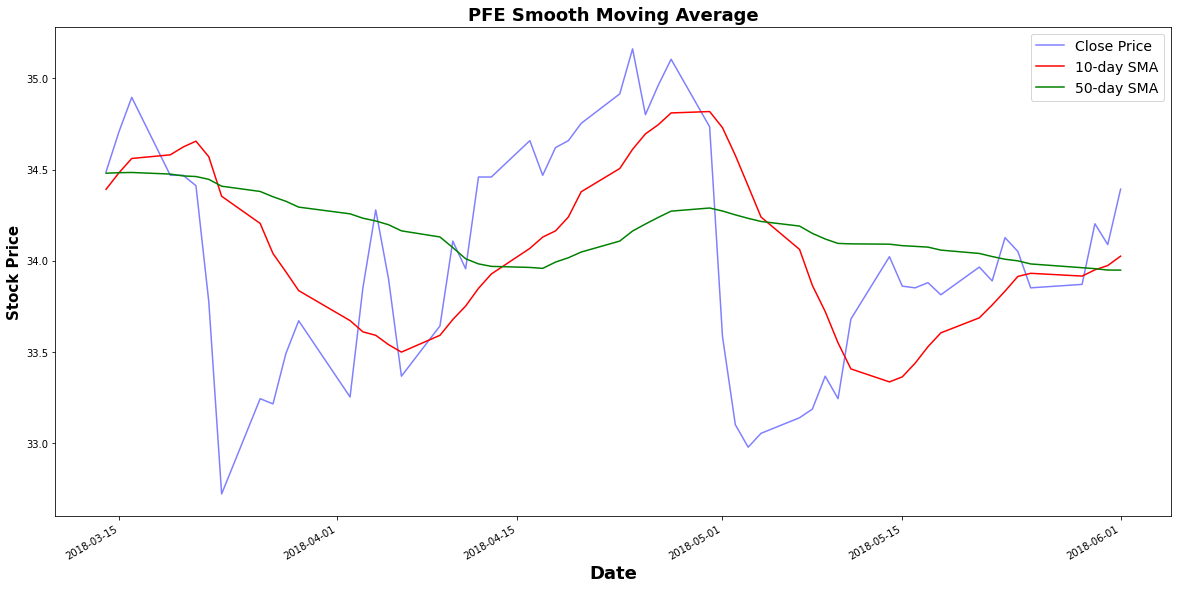

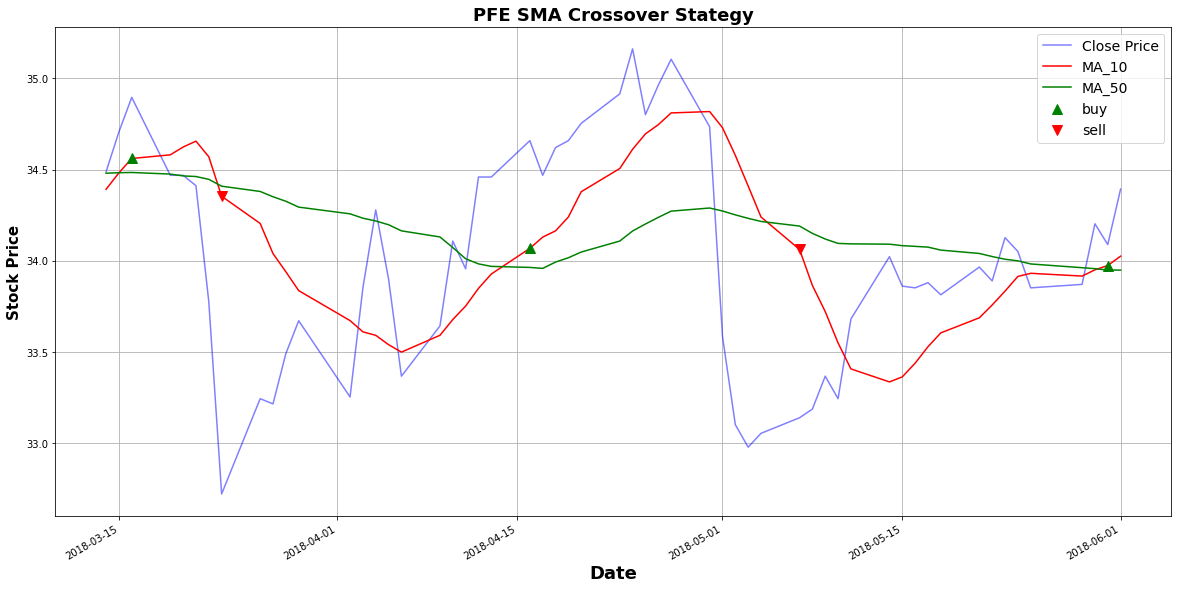

In [20]:
sma_rolling_3 = sma_function(sma_func_calc['2018-01-01':'2018-06-01'],col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_rolling_3;

In [21]:
print('Close Price')
print(sma_rolling_3['Close'].describe())
print()
print('10 Day Moving Average')
print(sma_rolling_3['MA_10'].describe())
print()
print('50 Day Moving Average')
print(sma_rolling_3['MA_50'].describe())

Close Price
count    56.000000
mean     34.015994
std       0.607358
min      32.722961
25%      33.629033
50%      33.961100
75%      34.468693
max      35.161289
Name: Close, dtype: float64

10 Day Moving Average
count    56.000000
mean     34.052809
std       0.430600
min      33.336811
25%      33.685484
50%      33.962524
75%      34.427893
max      34.817837
Name: MA_10, dtype: float64

50 Day Moving Average
count    56.000000
mean     34.168457
std       0.166282
min      33.949146
25%      34.021869
50%      34.140607
75%      34.272486
max      34.484061
Name: MA_50, dtype: float64


#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. This technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical price average.  https://www.investopedia.com/terms/e/ema.asp
 <br>

#### MACD Crossover
Short term moving average usually last 12 periods and long term last 26 periods.  The Signal line is generally a 9 period exponentially smooth average of the MACD line.  This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average.  This program uses the MACD Crossover to determine when to buy and sell stocks.<br>
A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes.  Whereas, a long-term moving average is deemed slower as it encapsulates prices over a longer period and a slower response to daily prices.<br>
The MACD line is calculated by taking the short term exponenrial moving average minus the long term exponetial moving average.  When the red line crosses above the green line you see an increase in the price and every time the red drops below the EMA26 you see the price decrease.<br>When MACD line crosses above the signal line that indicates a good time to buy and when it is below signal line that indcates a time to sell.

In [22]:
macd_df_1 = pfe_stock_data.copy()

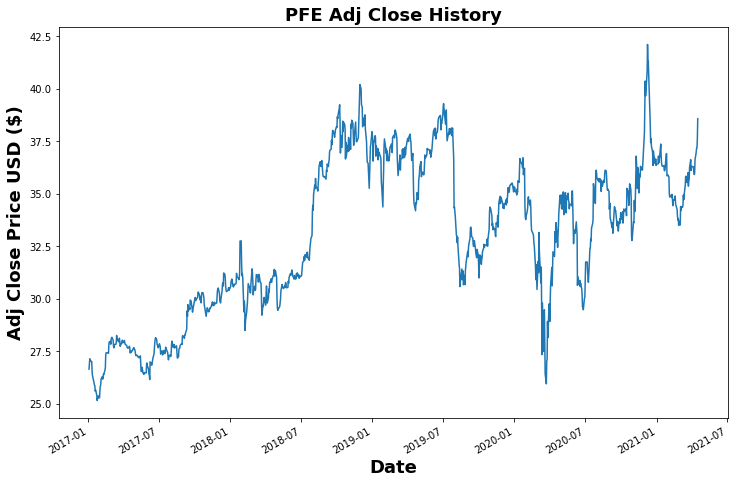

In [23]:
#ema_function(macd_df)
single_plot(macd_df_1, stock_value='Adj Close', stock_symbol='PFE')

#### Exponential Moving Average Crossover Stratergy
Stock market analysts and investors use Exponential Moving Average Crossover strategy, among other moving averages, to analyze price trends and predict upcoming change of trends.  A moving-average crossover occurs when plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period.  A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>

In [24]:
ewmal_2 = pfe_stock_data.copy() 

In [25]:
def ema_function(data, span1=None,span2=None):    
    # Create 20 days exponential moving average column
    data['12_EMA'] = data['Close'].ewm(span = span1, adjust = False).mean()
    # Create 50 days exponential moving average column
    data['26_EMA'] = data['Close'].ewm(span = span2, adjust = False).mean()

    #create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
    data['Signal'] = 0.0  
    data['Signal'] = np.where(data['12_EMA'] > data['26_EMA'], 1.0, 0.0)

    # create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
    data['Position'] = data['Signal'].diff()

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')
    # plot ‘buy’ signals
    plt.plot(data[ewmal_2['Position'] == 1].index, 
             data['12_EMA'][ewmal_2['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data['12_EMA'][data['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Stock Price', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Pfizer EWMA Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    
    return data

,Close,Volume,Adj Close,12_EMA,26_EMA,Signal,Position
Date,,,,,,,
2017-01-03,31.309298,23391844.0,26.653324,31.309298,31.309298,0.0,NaN
2017-01-04,31.584440,22753963.0,26.887548,31.351627,31.329679,1.0,1.0
2017-01-05,31.888046,21083584.0,27.146002,31.434153,31.371039,1.0,0.0
2017-01-06,31.764706,18418228.0,27.041008,31.485007,31.400200,1.0,0.0
2017-01-09,31.755219,21559886.0,27.032928,31.526578,31.426497,1.0,0.0
...,...,...,...,...,...,...,...
2021-04-12,36.970001,29944900.0,36.970001,36.201651,35.827295,1.0,0.0
2021-04-13,37.160000,33967400.0,37.160000,36.349089,35.926014,1.0,0.0
2021-04-14,37.169998,23842900.0,37.169998,36.475383,36.018161,1.0,0.0


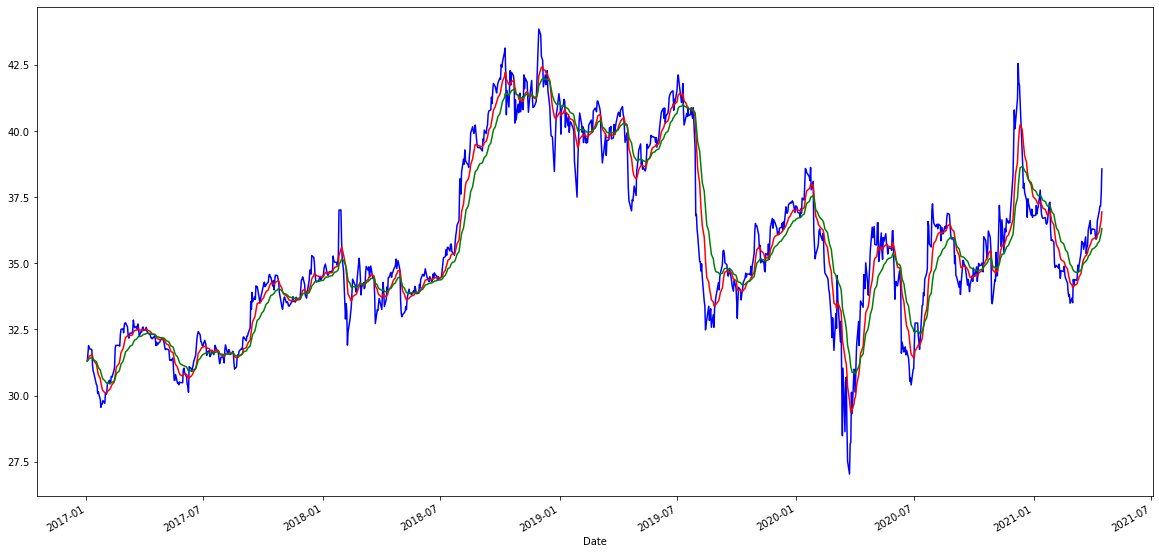

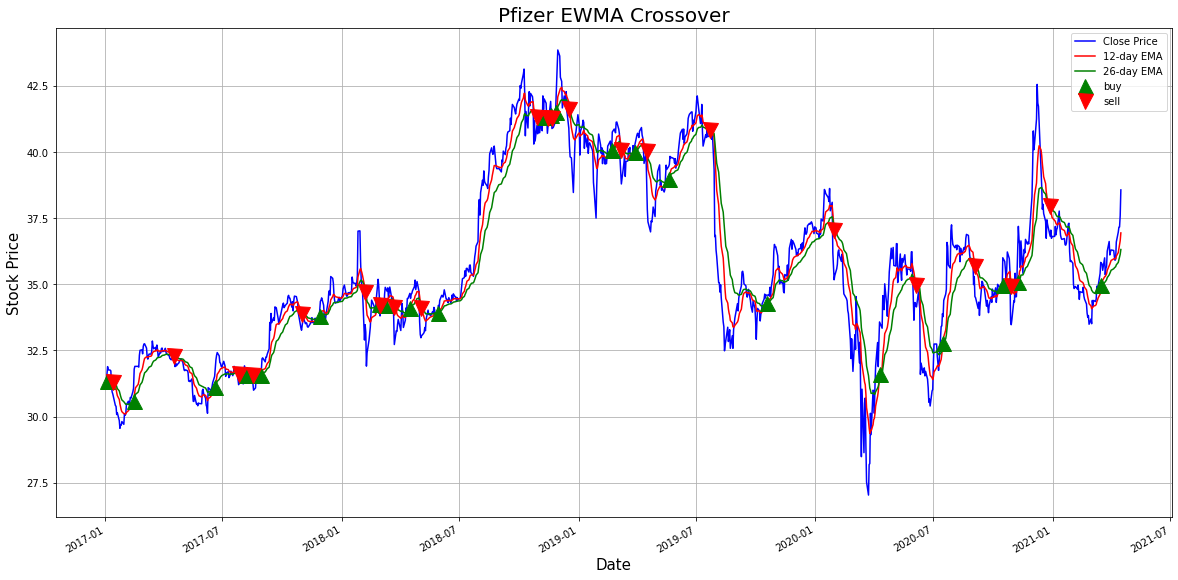

In [26]:
ewm_calc = ema_function(ewmal_2,span1 = 12,span2 = 26)
ewm_calc

In [27]:
#ewm_calc.head()

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



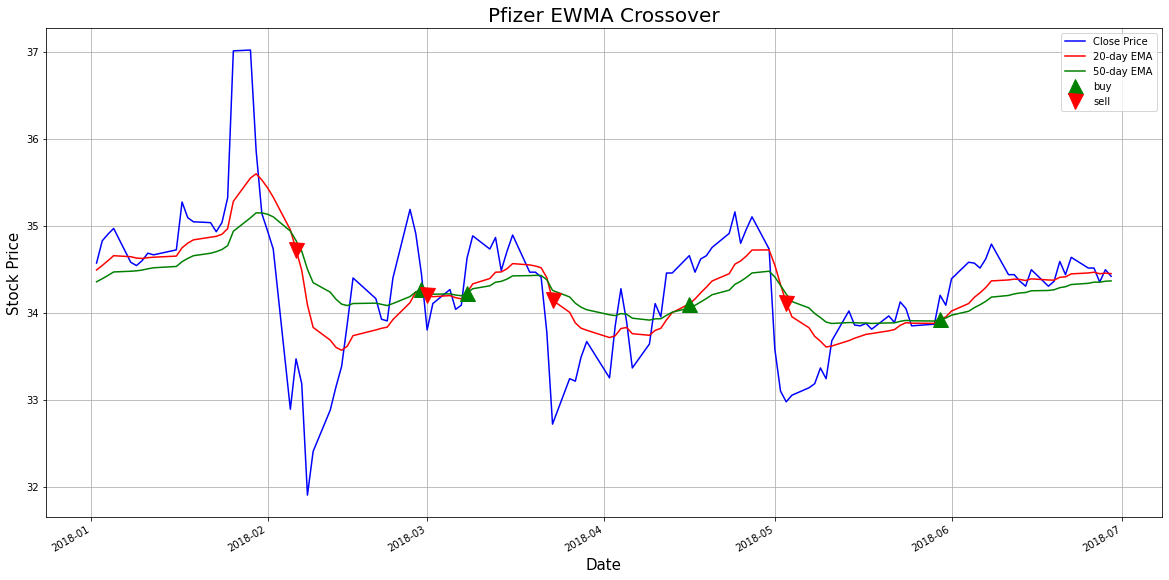

In [28]:
ewmal_3 = ewmal_2['2018-01-01':'2018-07-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
ewmal_3['Close'].plot(color = 'b', label= 'Close Price') 
ewmal_3['12_EMA'].plot(color = 'r',label = '20-day EMA') 
ewmal_3['26_EMA'].plot(color = 'g', label = '50-day EMA')
# plot ‘buy’ signals
plt.plot(ewmal_3[ewmal_2['Position'] == 1].index, 
         ewmal_3['12_EMA'][ewmal_2['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(ewmal_3[ewmal_3['Position'] == -1].index, 
         ewmal_3['12_EMA'][ewmal_3['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer EWMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Rate of Change
The Rate of Change (ROC) is a technical indicator that measures the percentage change between the most recent price and the price a specified number of days before. The indicator fluctuates around the zero line.
#### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? This is a complex question with multiple possible answer.  One possible answer is that as the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.  https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp<br>
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.



### Price Change in Dollars
To see how big the changes in price were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  A column named 'Actual_Changes' is added to calculate actual change in dollars.<br>For example, we can see that on 1/3/17 the Adj Closing price was 26.653324 and on 1/4/17 the Adj Closing price was 26.887548.  The price change $0.234224.<br> 

Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [29]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [30]:
#leavr off 1 b/c that's default value
#using shift function
#26.887548 - 26.653324 = 0.234224
def price_change_func(data, col1=None,stock_value=None):
    data['Actual_Changes'] = data[col1] - data[col1].shift(1)
    # price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 

    data['Actual_Changes'].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font) 
    
    return data

,Close,Volume,Adj Close,Actual_Changes
Date,,,,
2017-01-03,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.584440,22753963.0,26.887548,0.234224
2017-01-05,31.888046,21083584.0,27.146002,0.258453
2017-01-06,31.764706,18418228.0,27.041008,-0.104994
2017-01-09,31.755219,21559886.0,27.032928,-0.008080
...,...,...,...,...
2021-04-12,36.970001,29944900.0,36.970001,0.370003
2021-04-13,37.160000,33967400.0,37.160000,0.189999
2021-04-14,37.169998,23842900.0,37.169998,0.009998


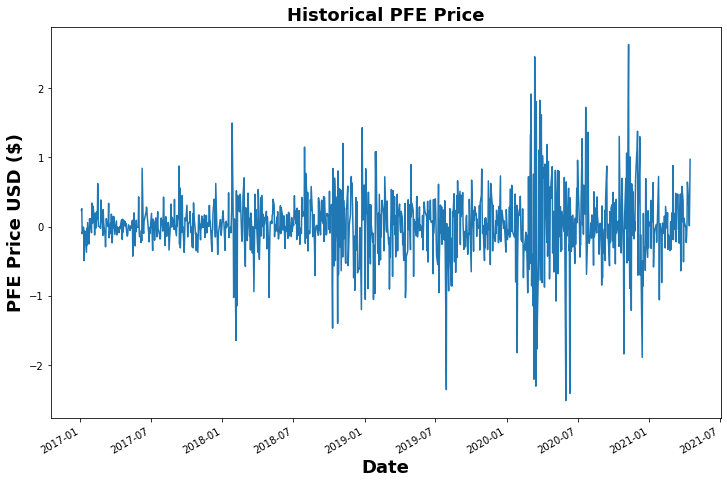

In [31]:
#price_change,
price_change_data = price_change_func(price_change,col1='Adj Close',stock_value='PFE')
price_change_data

The below graph shows that for the stated time the stock price difference was rarely positively more than $2.627 than negatviely more than -2.511.  The average daily return was 0.007375.<br>

In [32]:
#the mean (average) change was less than 1 cent
#absolute
price_change_1 = price_change.copy()
price_change_1['Actual_Changes'] = price_change_1['Actual_Changes'].abs() 
price_change_1['Actual_Changes'].describe()

count    1078.000000
mean        0.314681
std         0.355271
min         0.000000
25%         0.090277
50%         0.203424
75%         0.414892
max         2.627960
Name: Actual_Changes, dtype: float64

In [33]:
#single_plot(price_change, stock_value='Actual_Changes',stock_symbol='PFE')

In [34]:
#multi_stocks

In [35]:
multi_price_change = multi_stocks.copy()

MRNA, AZNA, JNJ didn't have a big daily price differece either psotively or negatively. NVAX did have spikes in daily price 
both psotively and negatively. NVAX average stock price is \\$41.94.  Around 2/21, the price spiked to 319.929 and 3.690000.  The price had increased \\$86.930 but then decreased \\$-34.299.<br>

In [36]:
def multi_price_change_func(data):
    data = data - data.shift(1)
    data.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return data

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.234224,-0.169662,0.800001,NaN,0.186050,NaN
2017-01-05,0.258453,1.080444,0.199999,NaN,0.642715,NaN
2017-01-06,-0.104994,-0.500038,1.000000,NaN,-0.219879,NaN
2017-01-09,-0.008080,-0.017860,1.000000,NaN,0.084570,NaN
...,...,...,...,...,...,...
2021-04-12,0.370003,0.389999,-4.090012,-1.520004,-0.520000,-0.620003
2021-04-13,0.189999,-2.160004,19.010010,10.310013,-0.230000,8.120003
2021-04-14,0.009998,0.440002,6.679993,10.319992,0.650002,2.960007


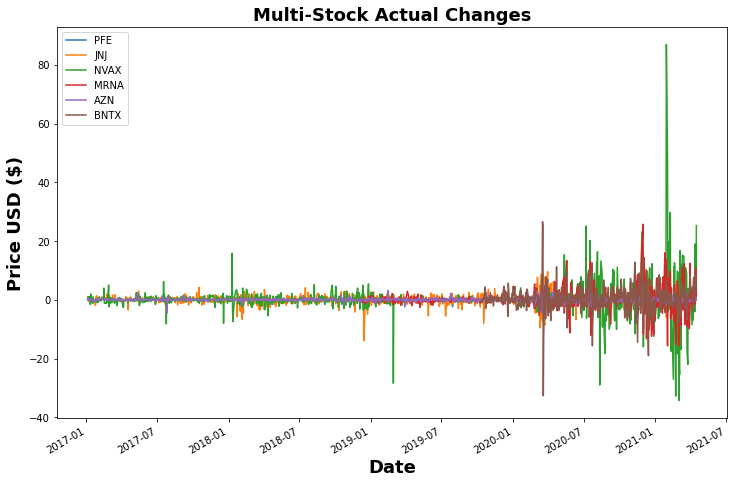

In [37]:
multi_price_calc = multi_price_change_func(multi_price_change)
multi_price_calc

In [38]:
multi_price_calc.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1078.000000,1078.000000,1078.000000,592.000000,1078.000000,381.000000
mean,0.011054,0.054549,0.187338,0.257111,0.025331,0.360367
std,0.474565,1.717994,5.492609,3.797264,0.682898,4.672170
min,-2.511635,-13.964050,-34.299988,-15.680008,-4.421049,-32.700001
25%,-0.177788,-0.582499,-0.600000,-0.727501,-0.248296,-1.790001
50%,0.009287,0.082512,0.000000,0.020000,0.027469,0.169998
75%,0.219101,0.796816,0.799999,1.072502,0.309018,2.360001
max,2.627960,9.590652,86.930008,25.710007,3.912495,26.599998


In [39]:
def hist_func_actual(data, col=None):
    plt.figure(figsize=(12,8))
    data[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Actual Change')
    plt.ylabel('Frequency')

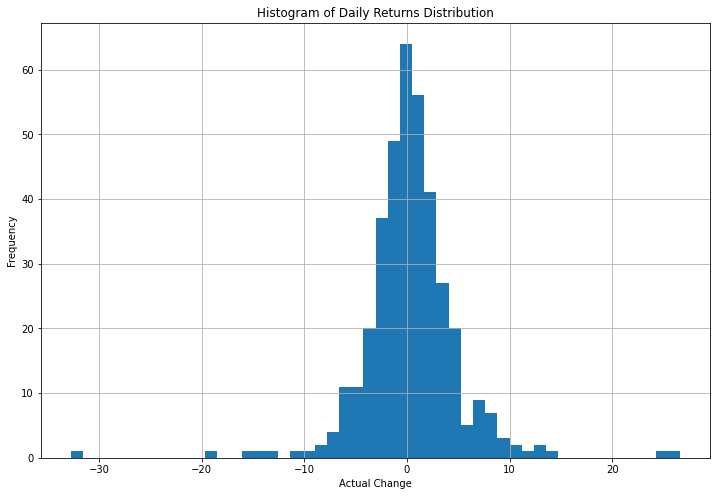

In [40]:
hist_func_actual(multi_price_calc, col='BNTX')

### Simple Daily Return
Daily price change as a percentage

In [41]:
multi_stocks.head()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN


In [42]:
(26.887548 /26.653324) -1

0.008787796974216056

In [43]:
#new price(cuurent time period) /old price - 1
#26.887548 - 26.653324=
#(26.200001 /25.400000) -1
def multi_price_change_func(data):
    daily_simple_returns = data.pct_change(1) #1 is for 1 day
    daily_simple_returns.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return daily_simple_returns

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009063,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003518,NaN
...,...,...,...,...,...,...
2021-04-12,0.010109,0.002419,-0.022755,-0.010786,-0.010413,-0.005076
2021-04-13,0.005139,-0.013363,0.108227,0.073960,-0.004654,0.066820
2021-04-14,0.000269,0.002759,0.034316,0.068933,0.013214,0.022833


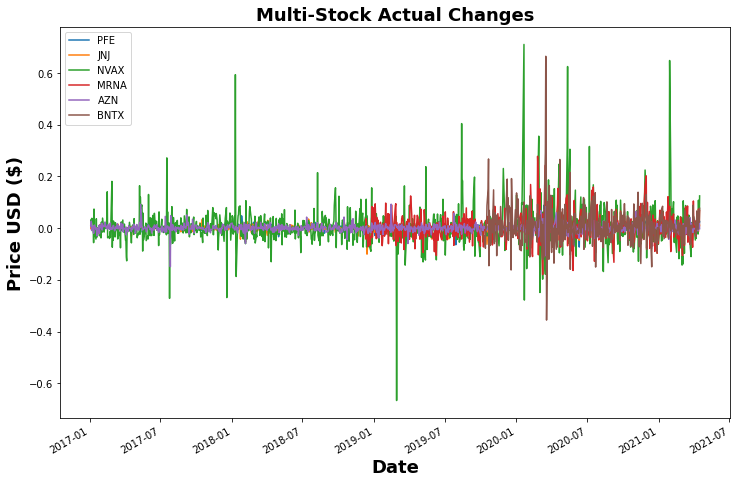

In [44]:
#percent change
#y % change
multi_dsr = multi_price_change_func(multi_stocks)
multi_dsr

In [45]:
#mean of daily simple return
#highest return should be NBTX and lowest for PFE
mean_dsr = multi_dsr.mean()
print('The Daily Mean Simple Return')
mean_dsr

The Daily Mean Simple Return


PFE     0.000446
JNJ     0.000505
NVAX    0.004894
MRNA    0.005079
AZN     0.000853
BNTX    0.008932
dtype: float64

In [46]:
def hist_func(data, col=None):
    plt.figure(figsize=(12,8))
    multi_dsr[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

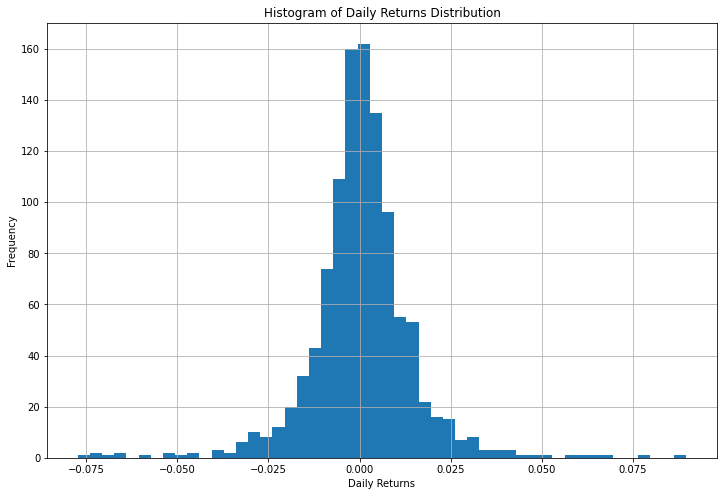

In [47]:
hist_func(multi_dsr, col='PFE')

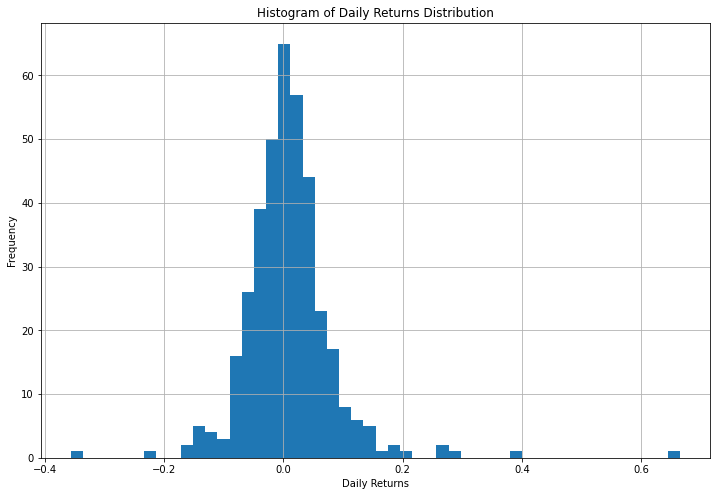

In [48]:
hist_func(multi_dsr, col='BNTX')

In [49]:
36.551258 - 37.603287

-1.0520290000000045

In [50]:
#stock volatility
#print standard deviaiton for daily simple return
#volatility is standard deviation
#Most volatile stock is NVAX, least volatile stock is JNJ
#the higher the volaitility the higher hte return, the lower volatility the lower return
#expect a lower return for JNJ as opposed to BNTX
#no absolute value, only abs when mean
#how different are thwy form each otehr
print('The Stock Volatility')
multi_dsr.std()

The Stock Volatility


PFE     0.014354
JNJ     0.013183
NVAX    0.076822
MRNA    0.052183
AZN     0.016447
BNTX    0.076228
dtype: float64

### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.  An asset is usually considered overbought when the value is above 70% and oversold when it is below 30%.  
https://www.investopedia.com/terms/r/rsi.asp Overbought refers that the bubble created from the buying might pop soon, and therefore the price will drop. This creates a strong entry point.  interpretation of the RSI is that values of 70 or above indicate that a security is becoming overvalued or overbought and may be due for a trend reversal or correction in price. An RSI value of 30 or below indicates an undervalued or oversold scenario.<br>
<br>
7/19-RSI value dips below 10 indicator, the 10 significant level.
    Tells us stock was oversold and presents a buying opportunity
On Adj Close plot was see that around 7/19 the price dipped from around \\$40.00 to \\$30.00.
    Then the price increased significantly again.
If you followed RSI you wuold have prucahsed around \\$30.00 and prcie jumped to \\$37.5 around 1/20.    

Around 7/18 to 9/18- Looks like stock was being over bought.  RSI value passed 80 level significant indicator.
    price was around \\$38.00 to \\$40.00.
    Pricde did drop to almost $35.00. Would have been a good time to drop prior to the drop.
    Would have saved some money from selling

In [51]:
rsi_df = pfe_stock_data.copy()
rsi_df

,Close,Volume,Adj Close
Date,,,
2017-01-03,31.309298,23391844.0,26.653324
2017-01-04,31.584440,22753963.0,26.887548
2017-01-05,31.888046,21083584.0,27.146002
2017-01-06,31.764706,18418228.0,27.041008
2017-01-09,31.755219,21559886.0,27.032928
...,...,...,...
2021-04-12,36.970001,29944900.0,36.970001
2021-04-13,37.160000,33967400.0,37.160000
2021-04-14,37.169998,23842900.0,37.169998


In [52]:
def rsi_function(data, col=None):
    rsi_d = data[col].diff(1)
    rsi_d = rsi_d.dropna()
    #get the postive gains (up) and negative gains(down)
    up = rsi_d.copy()
    down = rsi_d.copy()
    #get the postive values in delta
    up[up < 0]=0  #for any values in up that are less than 0. Any values n up that are less than 0, we'll set to 0
    down[down > 0]=0  #values in down that are greater than 0, they're positive. Set those values equal to 0.
    #up only contins positve values and down only contains negative values
    #Get the time period.  RSI is usually 14 day period
    period=14
    #calculate the average gain and average loss
    AVG_gain = up.rolling(window=period).mean()
    AVG_loss = abs(down.rolling(window=period).mean()) #going to be negative values so use absolute
    #calcualte RSI
    #calcualte relative strength (Rs)
    RS = AVG_gain / AVG_loss
    #calcualte relative strength Index (RSI)
    RSI = 100.0 - (100.0 / (1.0 + RS))
    #new dataframe
    new_df = pd.DataFrame()
    new_df[col] = rsi_df[col]
    new_df['RSI'] = RSI
    
    #plot column
    plt.figure(figsize=(12,8))
    plt.plot(new_df.index, new_df[col])
    plt.title(f'{col} Price History for Pfizer')
    plt.legend(new_df.columns.values, loc='upper left')
    #plot RSI values and signficant levels
    plt.figure(figsize=(12,8))
    plt.title('RSI')
    plt.plot(new_df.index,new_df['RSI'])
    plt.axhline(0, linestyle='--', alpha=0.5,color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5,color='green')
    plt.axhline(30, linestyle='--', alpha=0.5,color='red')
    plt.axhline(70, linestyle='--', alpha=0.5,color='red')
    plt.axhline(80, linestyle='--', alpha=0.5,color='green')
    plt.axhline(90, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5,color='gray')
    
    return new_df

,Adj Close,RSI
Date,,
2017-01-03,26.653324,NaN
2017-01-04,26.887548,NaN
2017-01-05,27.146002,NaN
2017-01-06,27.041008,NaN
2017-01-09,27.032928,NaN
...,...,...
2021-04-12,36.970001,61.975337
2021-04-13,37.160000,75.000026
2021-04-14,37.169998,73.214298


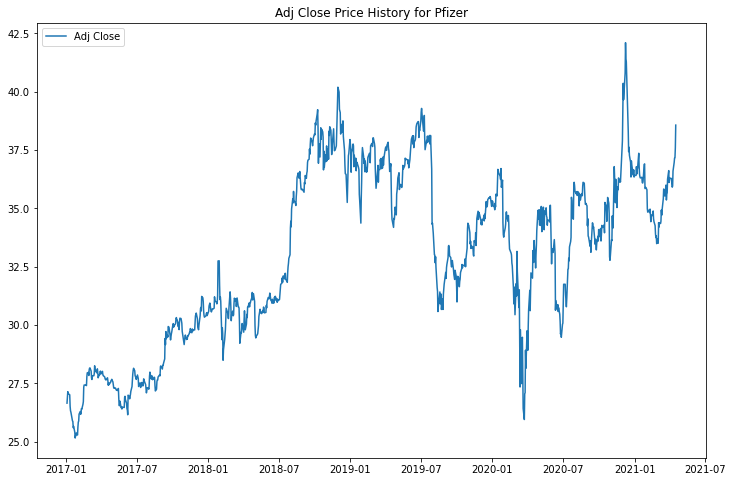

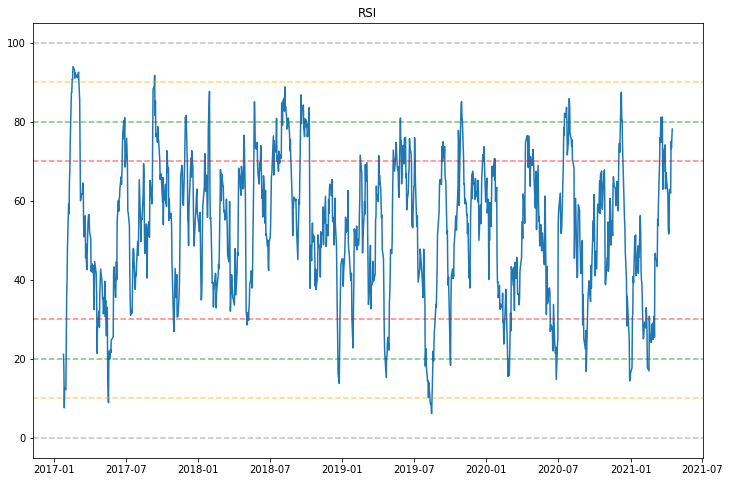

In [53]:
rsi_function(rsi_df, col='Adj Close')

### LSTM (Long Short Term Memory)
This section pertains to creating LSTM models to predict future stock prices.  LSTM networks are a type of artificial recurrent neural network architecture used in the field of deep learning. LSTM's are capable of learning order dependence in sequence prediction problems.  I am going to use the LSTM to predict the Adjusted Closing stock price of a corporation.  The LSTM is going to use the past 3 days stock prices.  I will use the Adj Close columns and calculations from technical Indicators for the LSTMs.

#### Multi-Stocks


In [54]:
multi_stocks

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-04-12,36.970001,161.639999,175.649994,139.399994,49.419998,121.519997
2021-04-13,37.160000,159.479996,194.660004,149.710007,49.189999,129.639999
2021-04-14,37.169998,159.919998,201.339996,160.029999,49.840000,132.600006


In [55]:
def delta_time_series(data,col=None):
#     data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
#     data['Percent_Chg'] = data[col].pct_change(1)
#     data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [56]:
multi = delta_time_series(multi_stocks, col='Adj Close')
multi

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2019-10-10,31.963688,124.006470,4.480000,14.160000,41.586590,14.240000
2019-10-11,32.249474,126.187592,4.560000,14.055000,41.567513,13.820000
2019-10-14,32.419167,125.601471,4.690000,13.930000,41.815510,12.750000
2019-10-15,32.597778,127.638466,4.830000,14.330000,42.168419,12.920000
2019-10-16,32.454887,129.877228,4.740000,14.150000,41.767818,12.940000
...,...,...,...,...,...,...
2021-04-12,36.970001,161.639999,175.649994,139.399994,49.419998,121.519997
2021-04-13,37.160000,159.479996,194.660004,149.710007,49.189999,129.639999
2021-04-14,37.169998,159.919998,201.339996,160.029999,49.840000,132.600006


In [57]:
multi.shape

(382, 6)

In [58]:
def plot_delta(data,col=None,symbol=None):
    data.plot(figsize=(12,6))
    label_font = {'weight':'bold','size':18}
    plt.title('Pharmaceutical Stocks Price History',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('Adj close')
    plt.show()

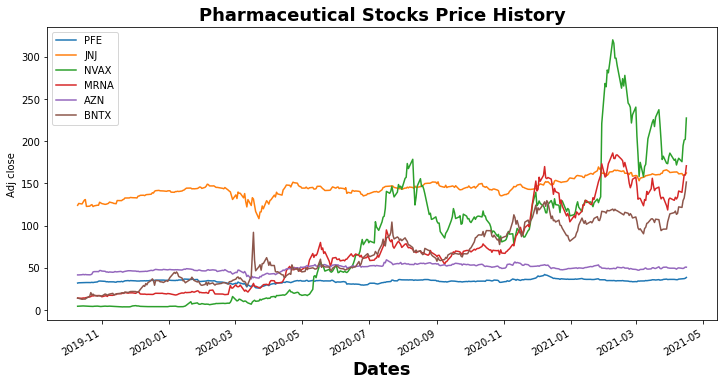

In [59]:
plot_delta(multi)

#### Train Test Split

In [60]:
train_size = int(len(multi) * 0.80)#0.67
test_size = len(multi) - train_size

In [61]:
multi.index[train_size]

Timestamp('2020-12-24 00:00:00')

In [62]:
multi.index[-test_size]


Timestamp('2020-12-24 00:00:00')

#### Plot Train Test Sets and Create Val Set

In [63]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot(figsize=(12,8))
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

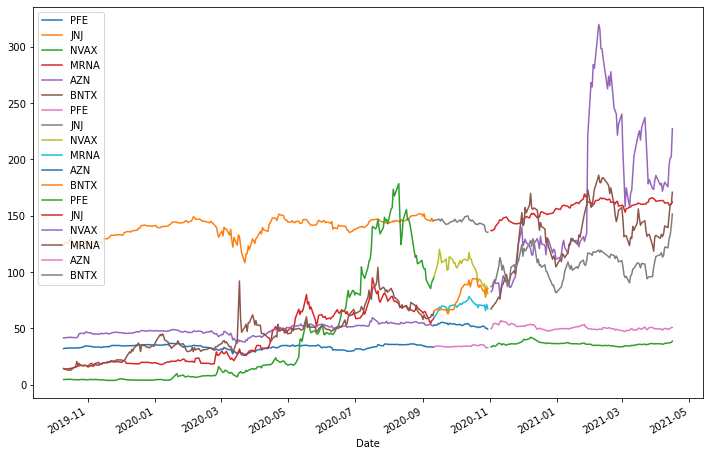

In [64]:
train, val, test= train_test_val(multi)

#### Preprocessing Data
##### Normalize Data
We're going to scale down all the values so they fit between 0 and 1. 

In [65]:
def scale_function(train, test,val):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [66]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [67]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [68]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

((233, 6), (36, 6), (114, 6))

How may days in the past do we want to look in the past to predict the next day price.

In [69]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

{'PFE': 0, 'JNJ': 1, 'NVAX': 2, 'MRNA': 3, 'AZN': 4, 'BNTX': 5}

In [70]:
col_index['PFE']

0

#### Timeseries Generator

In [71]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [72]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='PFE')

In [73]:
# ex_X, ex_y = train_data_gen[0]
# ex_X.shape

In [74]:
sample = ex_X[0]
sample.shape

(3, 6)

In [75]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [76]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist1 = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0851 - val_loss: 0.0088
Epoch 2/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0229 - val_loss: 0.0102
Epoch 3/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0228 - val_loss: 0.0044
Epoch 4/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0397
Epoch 5/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0150 - val_loss: 0.0027
Epoch 6/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0305
Epoch 7/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0119 - val_loss: 0.0057
Epoch 8/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0119 - val_loss: 0.0067
Epoch 00008: early stopping


In [77]:
model.evaluate_generator(test_data_gen)

0.1065792441368103

We can plot the training and validation accuracy and loss at each epoch 

In [78]:
def loss_plot(hist):#plt.plot(pd.DataFrame(hist.history))
    plt.figure(figsize=(10,8))
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

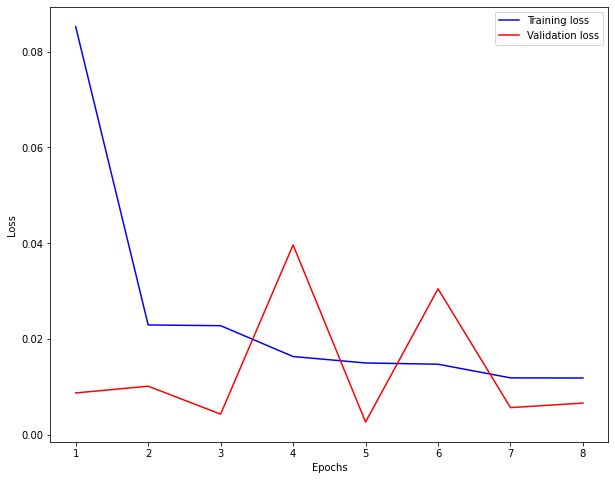

In [79]:
loss_plot(hist1)

In [80]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [81]:
# model_params = save_model(model)

In [82]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(230, 1)

In [83]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(111, 1)

In [84]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

230

In [85]:
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

111

In [86]:
def get_y_from_df(train_scaled_df, look_back, col='PFE', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [87]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

#### RMSE Function

In [88]:
#sc = MinMaxScaler(feature_range = (0, 1))
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# def model_metrics(y_train,y_hat_train):
#     trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
#     print('Train Score: %.2f RMSE' % (trainScore))
#     testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
#     print('Test Score: %.2f RMSE' % (testScore))
    
#     return trainScore, testScore

def model_metrics(y_test,y_hat_test):
    # calculate root mean squared error
#     y_test_i = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
#     y_hat_test_i = scaler.inverse_transform(np.array(y_hat_test).reshape(-1,1))
    
#     trainScore = math.sqrt(mean_squared_error(y_train_i, y_hat_train_i))
#     print('Train Score: %.2f RMSE' % (trainScore))
#     testScore = np.sqrt(mean_squared_error(y_test_i, y_hat_test_i))
    rmse=np.sqrt(np.mean(((y_hat_test - y_test)**2)))
    print('RMSE Test Score: %.2f RMSE' % (rmse))


In [89]:
#a value of 0 means predcitions were exact
#models got values exactly as they were supposed to from testing data

#model_metrics(y_train,y_hat_train)

model_metrics(y_test,y_hat_test)

RMSE Test Score: 0.24 RMSE


#### Prediction Plot

In [90]:
#red line is what model actually predicted
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()    

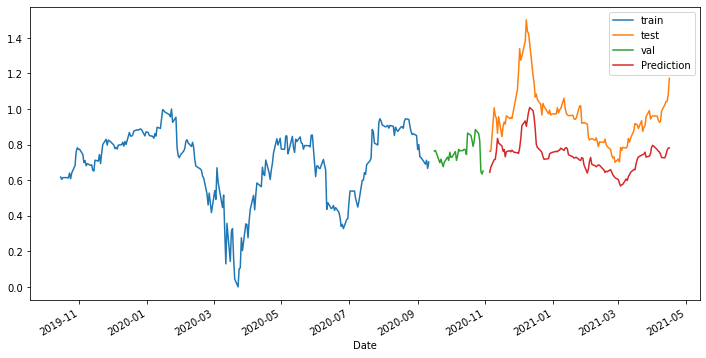

In [91]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM / Single Stock

In [92]:
#df_single.to_csv('single_stock')

# single = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
# single

In [93]:
# pfe_stock_data
pfe_stock_data

,Close,Volume,Adj Close
Date,,,
2017-01-03,31.309298,23391844.0,26.653324
2017-01-04,31.584440,22753963.0,26.887548
2017-01-05,31.888046,21083584.0,27.146002
2017-01-06,31.764706,18418228.0,27.041008
2017-01-09,31.755219,21559886.0,27.032928
...,...,...,...
2021-04-12,36.970001,29944900.0,36.970001
2021-04-13,37.160000,33967400.0,37.160000
2021-04-14,37.169998,23842900.0,37.169998


In [94]:
def delta_time_series1(data,col=None):
    data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [95]:
single = delta_time_series1(pfe_stock_data, col='Adj Close')
single

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Volume,Adj Close,Actual_Changes,Percent_Chg,MA_50
Date,,,,,,
2017-03-15,32.855785,24279839.0,28.254789,0.388992,0.011981,26.801835
2017-03-16,32.666035,21816219.0,28.091606,-0.189751,-0.005775,26.830601
2017-03-17,32.561668,45736117.0,28.001856,-0.104366,-0.003195,26.852887
2017-03-20,32.618595,18435514.0,28.050808,0.056927,0.001748,26.870983
2017-03-21,32.495255,33083479.0,27.944742,-0.123341,-0.003781,26.889058
...,...,...,...,...,...,...
2021-04-12,36.970001,29944900.0,36.970001,0.370003,0.010109,35.132800
2021-04-13,37.160000,33967400.0,37.160000,0.189999,0.005139,35.158000
2021-04-14,37.169998,23842900.0,37.169998,0.009998,0.000269,35.185400


In [96]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [97]:
train_size = int(len(single) * 0.80)#0.67
test_size = len(single) - train_size

In [98]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

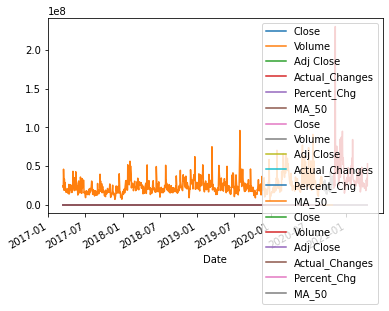

In [99]:
train, val, test= train_test_val(single)

In [100]:
def scale_function(train, test,val):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [101]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [102]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [103]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

((881, 6), (36, 6), (114, 6))

In [104]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

{'Close': 0,
 'Volume': 1,
 'Adj Close': 2,
 'Actual_Changes': 3,
 'Percent_Chg': 4,
 'MA_50': 5}

In [105]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [106]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Adj Close')

In [107]:
sample = ex_X[0]
sample.shape

(3, 6)

#### Build LSTM Model

In [108]:
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = True))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

model1.add(Dense(units = 25,activation='relu'))
model1.add(Dense(units = 1))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [109]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist2 = model1.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/25
293/293 [==============================] - 3s 10ms/step - loss: 0.0309 - val_loss: 0.0163
Epoch 2/25
293/293 [==============================] - 3s 10ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 3/25
293/293 [==============================] - 2s 8ms/step - loss: 0.0054 - val_loss: 0.0187
Epoch 4/25
293/293 [==============================] - 3s 9ms/step - loss: 0.0054 - val_loss: 0.0146
Epoch 5/25
293/293 [==============================] - 3s 9ms/step - loss: 0.0042 - val_loss: 0.0146
Epoch 00005: early stopping


In [110]:
model1.evaluate_generator(test_data_gen)

0.006848976481705904

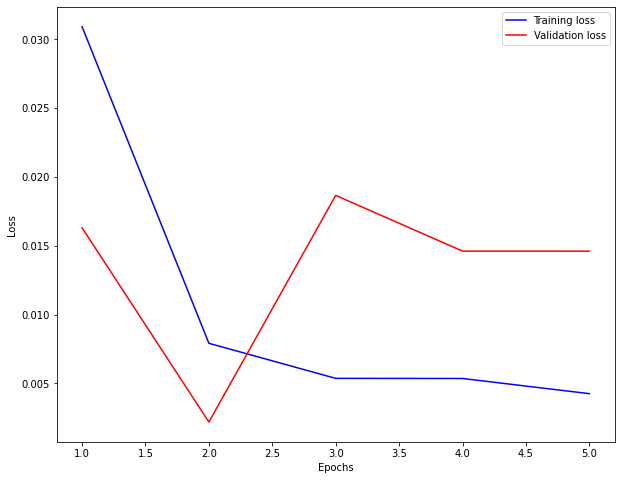

In [111]:
#pd.DataFrame(hist.history).plot()

loss_plot(hist2)

In [112]:
trainPredict = model1.predict_generator(train_data_gen)
trainPredict.shape

(878, 1)

In [113]:
testPredict = model1.predict_generator(test_data_gen)
testPredict.shape

(111, 1)

In [114]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

878

In [115]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
y_hat_test.shape

(111,)

In [116]:
train_scaled_df.shape, test_scaled_df.shape

((881, 6), (114, 6))

In [117]:
y_train = get_y_from_df(train_scaled_df, look_back)
y_test = get_y_from_df(test_scaled_df, look_back)
y_train = get_y_from_df(train_scaled_df, look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [118]:
y_train.shape, y_test.shape, y_val.shape

((878,), (111,), (33,))

In [119]:
y_hat_test.shape

(111,)

In [120]:
# y_train = get_y_from_df(train_scaled_df,look_back)
# y_test = get_y_from_df(test_scaled_df,look_back)
# y_train = get_y_from_df(train_scaled_df,look_back)
# y_val = get_y_from_df(val_scaled_df,look_back)

In [121]:
# def model_metrics(y_train,y_hat_train):
#     # calculate root mean squared error
#     trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
#     print('Train Score: %.2f RMSE' % (trainScore))
#     testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
#     print('Test Score: %.2f RMSE' % (testScore))
    
#     return trainScore, testScore

In [122]:
#what in normalized

#model_metrics(y_train,y_hat_train)

In [123]:
def model_metrics(y_test,y_hat_test):

#     y_test_i = scaler.inverse_transform(np.array(y_test).reshape(-1,1))
#     y_hat_test_i = scaler.inverse_transform(np.array(y_hat_test).reshape(-1,1))

    rmse=np.sqrt(np.mean(((y_hat_test- y_test)**2)))
    print('Test Score: %.2f RMSE' % (rmse))
    
    #return y_train_i, y_hat_train_i, y_test_i, y_hat_test_i, trainScore, testScore



In [124]:
model_metrics(y_test,y_hat_test)

Test Score: 0.06 RMSE


In [125]:
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

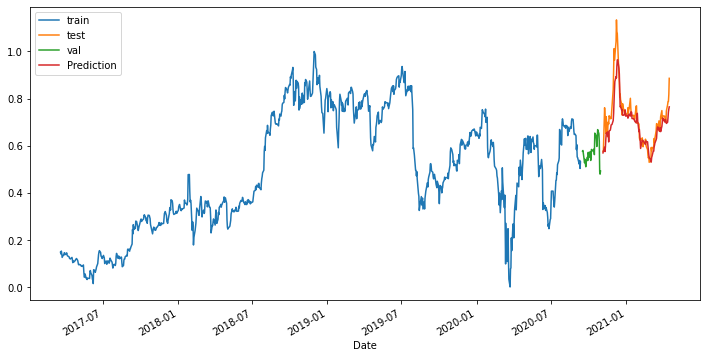

In [126]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM and Technical Indicators

#### Moving Average 50 Days

In [127]:
col_index['MA_50']

5

In [128]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='MA_50')

In [129]:
sample = ex_X[0]
sample.shape

(3, 6)

In [130]:
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = False))
model2.add(Dropout(0.2))

model2.add(Dense(units = 25))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

model2.summary()    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

In [131]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist3 = model2.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/50
293/293 [==============================] - 4s 12ms/step - loss: 0.0227 - val_loss: 0.0022
Epoch 2/50
293/293 [==============================] - 5s 19ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/50
293/293 [==============================] - 4s 14ms/step - loss: 0.0034 - val_loss: 4.4000e-04
Epoch 4/50
293/293 [==============================] - 3s 9ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 5/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 1.7280e-04
Epoch 6/50
293/293 [==============================] - 3s 10ms/step - loss: 0.0021 - val_loss: 6.8743e-04
Epoch 7/50
293/293 [==============================] - 4s 13ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/50
293/293 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 2.9000e-04
Epoch 00008: early stopping


In [132]:
model2.evaluate_generator(test_data_gen)

1.0725595529947896e-05

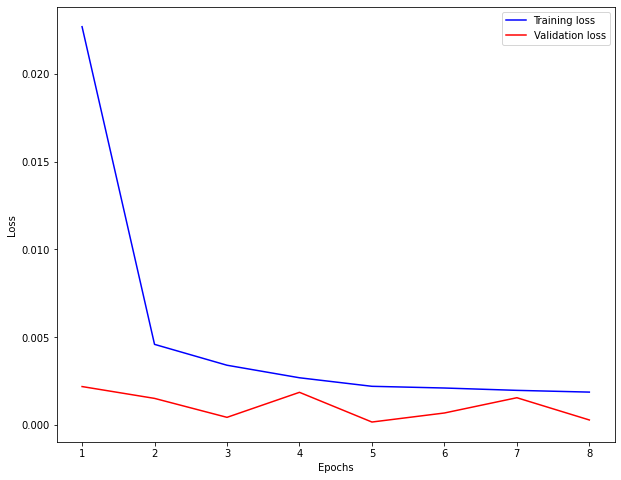

In [133]:
#pd.DataFrame(hist.history).plot()
loss_plot(hist3)

In [134]:
def get_y_from_df(train_scaled_df, look_back, col='MA_50'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [135]:
trainPredict = model2.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model2.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [136]:
model_metrics(y_train,y_hat_train)

Test Score: 0.02 RMSE


In [137]:
model_metrics(y_test,y_hat_test)

Test Score: 0.02 RMSE


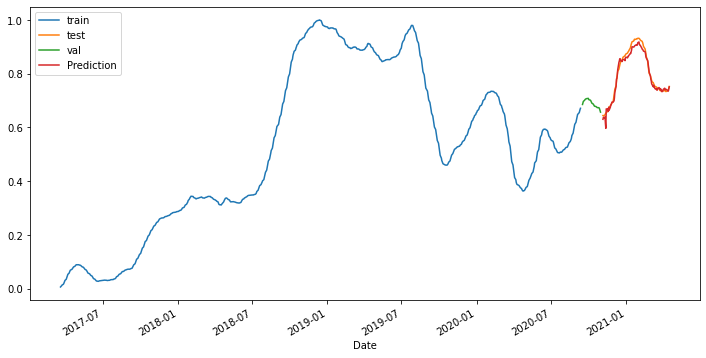

In [138]:
# plt.figure(figsize=(12,6))
# y_train.plot(label='train')
# y_test.plot(label='test')
# y_val.plot(label='val')
# y_hat_test.plot(label='Prediction')
# #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
# plt.legend()
prediction_plot(y_train,y_test,y_val,y_hat_test)

### Actual_Changes

In [139]:
#dollar amount change
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Actual_Changes')

In [140]:
model3 = Sequential()

model3.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = False))
model3.add(Dropout(0.2))

model3.add(Dense(units = 25, activation='relu'))
model3.add(Dense(units = 1))

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

model3.summary()    

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 50)             11400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)               

In [141]:
hist4 = model3.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,
                           callbacks=[early_stop])

Epoch 1/50
293/293 [==============================] - 3s 9ms/step - loss: 0.0213 - val_loss: 0.0510
Epoch 2/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0111 - val_loss: 0.0437
Epoch 3/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0110 - val_loss: 0.0424
Epoch 4/50
293/293 [==============================] - 3s 10ms/step - loss: 0.0105 - val_loss: 0.0483
Epoch 5/50
293/293 [==============================] - 3s 10ms/step - loss: 0.0100 - val_loss: 0.0441
Epoch 6/50
293/293 [==============================] - 3s 9ms/step - loss: 0.0101 - val_loss: 0.0472
Epoch 00006: early stopping


In [142]:
model3.evaluate_generator(test_data_gen)

0.013116374611854553

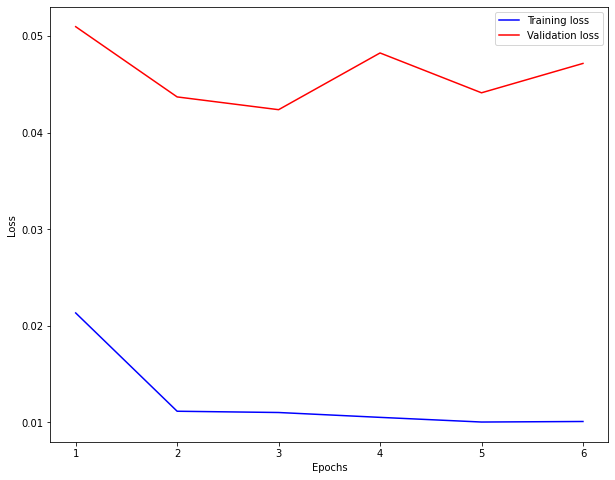

In [143]:
#pd.DataFrame(hist.history).plot()
loss_plot(hist4)

In [144]:
def get_y_from_df(train_scaled_df, look_back, col='Actual_Changes'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [145]:
#plt.plot(trainPredict)

In [146]:
trainPredict = model3.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model3.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
#y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [147]:
model_metrics(y_train,y_hat_train)

Test Score: 0.10 RMSE


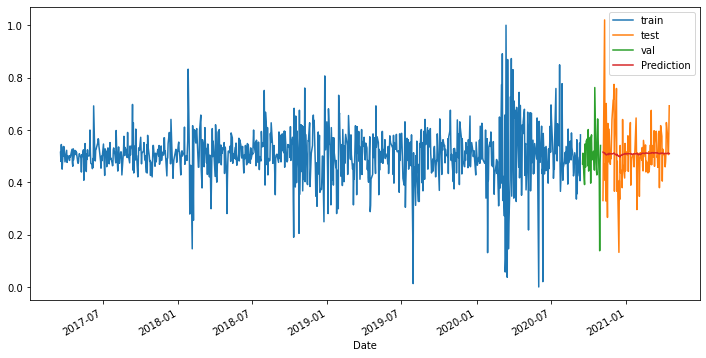

In [148]:
prediction_plot(y_train,y_test,y_val,y_hat_test)